In [1]:
import scipy
from scipy import stats
import pickle 
from sklearn.neighbors import KernelDensity

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import math 
import collections
from pycocotools.coco import COCO
import requests
import plotly.express as px
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
import base64
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import operator
import plotly.figure_factory as ff
import scipy
import pickle 
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from collections import OrderedDict
from random import sample


/tmp/ipykernel_35030/3201064205.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Vanilla Stratified Beta Sampling

In [5]:
'''
* Traditional stratified beta sampling, given a beta distribution, 
    generate how much to sample from each bucket based on the cdf
* This does not ensure we are sampling up to the training budget 
'''

def stratified_beta_multilabel(df, alpha, beta, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()

    #unique_targets = df['Target'].unique()
    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    #confidence = np.array(df['confidence'].tolist())
    variability = np.array(df['variability'].tolist())


    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    df_variability = pd.DataFrame({'variability':variability, 'question_id':question_ids})
    bins = pd.cut(variability, bins=np.linspace(0, 0.5, 6), right=True, retbins=True)
    df_variability['bins'] = bins[0]
    
    beta_distribution = scipy.stats.beta(alpha, beta)
    sampling_percentages = [beta_distribution.cdf(0.2), beta_distribution.cdf(0.4)-beta_distribution.cdf(0.2), beta_distribution.cdf(0.6)-beta_distribution.cdf(0.4), beta_distribution.cdf(0.8)-beta_distribution.cdf(0.6), beta_distribution.cdf(1) - beta_distribution.cdf(0.8)]
    #sampling_percentages = [beta_distribution.cdf(0.25), beta_distribution.cdf(0.5)-beta_distribution.cdf(0.25), beta_distribution.cdf(0.75)-beta_distribution.cdf(0.5), beta_distribution.cdf(1)-beta_distribution.cdf(0.75)]
    unique_bins = df_variability['bins'].unique().tolist()
    print(unique_bins)

    first_bin = df_variability.loc[df_variability['bins'] == unique_bins[2]]
    second_bin = df_variability.loc[df_variability['bins'] == unique_bins[0]]
    third_bin = df_variability.loc[df_variability['bins'] == unique_bins[1]]
    fourth_bin = df_variability.loc[df_variability['bins'] == unique_bins[3]]
    fifth_bin = df_variability.loc[df_variability['bins'] == unique_bins[4]]

    all_bins = [first_bin, second_bin, third_bin, fourth_bin, fifth_bin]
    final_sample = []
    final_sample_ids = []
    for idx, sampling_percentage in enumerate(sampling_percentages):
        sampled_points = all_bins[idx].sample(frac=sampling_percentage, replace=False)
        final_sample.extend(sampled_points['variability'].tolist())
        final_sample_ids.extend(sampled_points['question_id'].tolist())
    sns.histplot(final_sample, kde=True)
    total_samples = round((training_budget*0.01) * len(all_ids))
    print("Total samples: ", total_samples)
    print("sample size: ", len(set(final_sample)))


    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/beta/var_stratified/seed_'+str(965)+'/alpha_'+str(alpha)+'_beta_'+str(beta)+'_budget_'+str(training_budget)+'.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    # sampled_targets_unique = [] # unique targets in sampled data
    # sampled_targets = set(unique_targets_sample['Target'].unique())
    # for sample in sampled_targets:
    #     target_list = [x.strip() for x in sample.split(',')]
    #     sampled_targets_unique.extend(target_list)
    # sampled_targets_unique = set(sampled_targets_unique)
    targets_excluded = unique_targets - unique_targets_sampled
    print("TARGETS excluded: ", len(targets_excluded))

    print("unique targets max variability per class: ", len(set(unique_targets_sampled)))
    print('samples - max variability per class: ', len(set(final_sample)))
    print('all_samples - max variability per class: ', len(all_ids))

[Interval(0.1, 0.2, closed='right'), Interval(0.2, 0.3, closed='right'), Interval(0.0, 0.1, closed='right'), Interval(0.3, 0.4, closed='right'), Interval(0.4, 0.5, closed='right')]
Total samples:  198205
sample size:  154715
TARGETS excluded:  4
unique targets max variability per class:  3124
samples - max variability per class:  154715
all_samples - max variability per class:  619390


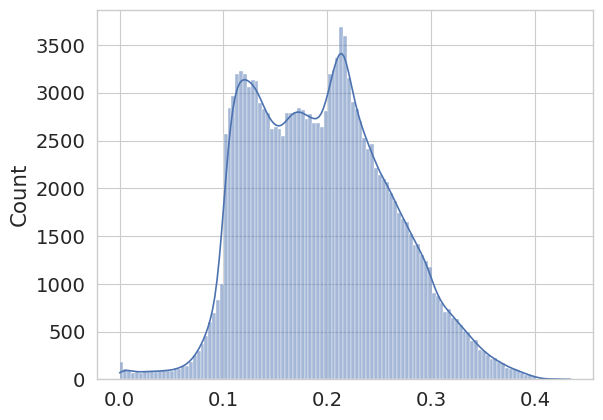

In [6]:

sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'


base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

stratified_beta_multilabel(df, 2, 2, sampling_model, 32, dataset=sampling_dataset)

# Stratified to reach budget

In [2]:
'''
* Generate sampling percentages from beta cdf similar to vanilla stratified beta sampling, 
but determine the number of examples to sample by taking that percentage of the budget
* If there are not enough samples in that bucket, just take all the samples from that bucket 
* This still does not ensure we reach our training budget 
'''
def stratified_beta_multilabel_mod(df, alpha, beta, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()
    total_samples = round((training_budget*0.01) * len(all_ids))

    # sampled_question_ids = []
    # sampled_variabilities = []
    # sampled_confidence = []
    # sampled_correctness = []
    # sampled_targets = []

    #unique_targets = df['Target'].unique()
    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    #confidence = np.array(df['confidence'].tolist())
    variability = np.array(df['variability'].tolist())


    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    df_variability = pd.DataFrame({'variability':variability, 'question_id':question_ids})
    bins = pd.cut(variability, bins=np.linspace(0, 0.5, 6), right=True, retbins=True)
    df_variability['bins'] = bins[0]
    
    beta_distribution = scipy.stats.beta(alpha, beta)
    sampling_percentages = [beta_distribution.cdf(0.2), beta_distribution.cdf(0.4)-beta_distribution.cdf(0.2), beta_distribution.cdf(0.6)-beta_distribution.cdf(0.4), beta_distribution.cdf(0.8)-beta_distribution.cdf(0.6), beta_distribution.cdf(1) - beta_distribution.cdf(0.8)]
    #sampling_percentages = [beta_distribution.cdf(0.25), beta_distribution.cdf(0.5)-beta_distribution.cdf(0.25), beta_distribution.cdf(0.75)-beta_distribution.cdf(0.5), beta_distribution.cdf(1)-beta_distribution.cdf(0.75)]
    unique_bins = df_variability['bins'].unique().tolist()
    print(unique_bins)

    first_bin = df_variability.loc[df_variability['bins'] == unique_bins[2]]
    second_bin = df_variability.loc[df_variability['bins'] == unique_bins[0]]
    third_bin = df_variability.loc[df_variability['bins'] == unique_bins[1]]
    fourth_bin = df_variability.loc[df_variability['bins'] == unique_bins[3]]
    fifth_bin = df_variability.loc[df_variability['bins'] == unique_bins[4]]

    all_bins = [first_bin, second_bin, third_bin, fourth_bin, fifth_bin]
    final_sample = []
    final_sample_ids = []
    for idx, sampling_percentage in enumerate(sampling_percentages):
        num_samples = round(sampling_percentage * total_samples)
        if num_samples > len(all_bins[idx]):
            print('idx: ', idx)
            print(num_samples)
            print(len(all_bins[idx]))
            num_samples = len(all_bins[idx])
        
        sampled_points = all_bins[idx].sample(n=num_samples, replace=False)
        final_sample.extend(sampled_points['variability'].tolist())
        final_sample_ids.extend(sampled_points['question_id'].tolist())
    sns.histplot(final_sample, kde=True)
    print("Total samples: ", total_samples)
    print("sample size: ", len(set(final_sample)))


    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/beta/var_stratified/seed_'+str(965)+'/alpha_'+str(alpha)+'_beta_'+str(beta)+'_budget_'+str(training_budget)+'mod.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    # sampled_targets_unique = [] # unique targets in sampled data
    # sampled_targets = set(unique_targets_sample['Target'].unique())
    # for sample in sampled_targets:
    #     target_list = [x.strip() for x in sample.split(',')]
    #     sampled_targets_unique.extend(target_list)
    # sampled_targets_unique = set(sampled_targets_unique)
    targets_excluded = unique_targets - unique_targets_sampled
    print("TARGETS excluded: ", len(targets_excluded))

    print("unique targets max variability per class: ", len(set(unique_targets_sampled)))
    print('samples - max variability per class: ', len(set(final_sample)))
    print('all_samples - max variability per class: ', len(all_ids))

[Interval(0.1, 0.2, closed='right'), Interval(0.2, 0.3, closed='right'), Interval(0.0, 0.1, closed='right'), Interval(0.3, 0.4, closed='right'), Interval(0.4, 0.5, closed='right')]
idx:  4
37163
443
Total samples:  185817
sample size:  149095
TARGETS excluded:  3
unique targets max variability per class:  3125
samples - max variability per class:  149095
all_samples - max variability per class:  619390


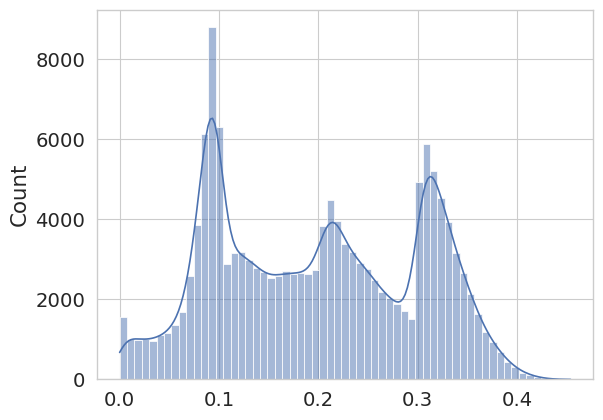

In [12]:

sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'


base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

stratified_beta_multilabel_mod(df, 1, 1, sampling_model, 30, dataset=sampling_dataset) 

# stratified sampling from 30% of highest frequency bins

In [14]:
'''
* Just take the mode of the histogram of variability distributions and sample 30% from there

* With the way our data is distributed, this ensures we sample up to the training budget 
'''
def stratified_beta_multilabel_middle(df, lower, upper, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()
    total_samples = round((training_budget*0.01) * len(all_ids))

    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    variability = np.array(df['variability'].tolist())


    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    df_variability = pd.DataFrame({'variability':variability, 'question_id':question_ids})
    bins = pd.cut(variability, bins=np.linspace(0, 0.5, 6), right=True, retbins=True)
    df_variability['bins'] = bins[0]
    
    #beta_distribution = scipy.stats.beta(alpha, beta)
    #sampling_percentages = [beta_distribution.cdf(0.2), beta_distribution.cdf(0.4)-beta_distribution.cdf(0.2), beta_distribution.cdf(0.6)-beta_distribution.cdf(0.4), beta_distribution.cdf(0.8)-beta_distribution.cdf(0.6), beta_distribution.cdf(1) - beta_distribution.cdf(0.8)]
    #sampling_percentages = [beta_distribution.cdf(0.25), beta_distribution.cdf(0.5)-beta_distribution.cdf(0.25), beta_distribution.cdf(0.75)-beta_distribution.cdf(0.5), beta_distribution.cdf(1)-beta_distribution.cdf(0.75)]
    unique_bins = df_variability['bins'].unique().tolist()
    print(unique_bins)

    first_bin = df_variability.loc[df_variability['bins'] == unique_bins[2]]
    second_bin = df_variability.loc[df_variability['bins'] == unique_bins[0]]
    third_bin = df_variability.loc[df_variability['bins'] == unique_bins[1]]
    fourth_bin = df_variability.loc[df_variability['bins'] == unique_bins[3]]
    fifth_bin = df_variability.loc[df_variability['bins'] == unique_bins[4]]
    all_bins = [first_bin, second_bin, third_bin, fourth_bin, fifth_bin]

    bins_range= [0.0, 0.1, 0.2, 0.3, 0.4]
    idx_lower = bins_range.index(lower)
    idx_upper = bins_range.index(upper) 

    frames = []
    # come up with automated way to append frames given an upper and lower range 
    if idx_lower == (idx_upper - 1):
        frames.append(all_bins[idx_lower])
    else:
        frames.append(all_bins[idx_lower])
        frames.append(all_bins[idx_upper - 1])

    # if idx_upper != idx_lower + 1:

    result = pd.concat(frames)

    final_sample_df = result.sample(n=total_samples, replace=False)
    final_sample = final_sample_df['variability'].tolist()
    final_sample_ids = final_sample_df['question_id'].tolist()


    sns.histplot(final_sample, kde=True)
    print("Total samples: ", total_samples)
    print("sample size: ", len(set(final_sample)))


    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/beta/var_stratified/seed_'+str(965)+'/middle_buckets_' + str(lower) + '_' + str(upper) + '.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    targets_excluded = unique_targets - unique_targets_sampled
    print(targets_excluded)
    print("TARGETS excluded: ", len(targets_excluded))

    print("unique targets max variability per class: ", len(set(unique_targets_sampled)))
    print('samples - max variability per class: ', len(set(final_sample)))
    print('all_samples - max variability per class: ', len(all_ids))

[Interval(0.1, 0.2, closed='right'), Interval(0.2, 0.3, closed='right'), Interval(0.0, 0.1, closed='right'), Interval(0.3, 0.4, closed='right'), Interval(0.4, 0.5, closed='right')]
        variability  question_id        bins
668     0.412349     410849002    (0.4, 0.5]
13337   0.400280     279034019    (0.4, 0.5]
20556   0.413863     33799001     (0.4, 0.5]
22213   0.403165     558015002    (0.4, 0.5]
22642   0.400942     53587000     (0.4, 0.5]
...          ...          ...            ...
609810  0.410467     316154005    (0.4, 0.5]
611410  0.403705     116825002    (0.4, 0.5]
612010  0.400888     568107002    (0.4, 0.5]
613535  0.405620     219250001    (0.4, 0.5]
617708  0.409107     237542004    (0.4, 0.5]

[443 rows x 3 columns]
Total samples:  185817
sample size:  185817
{'1 4', '1 in back'}
TARGETS excluded:  2
unique targets max variability per class:  3126
samples - max variability per class:  185817
all_samples - max variability per class:  619390


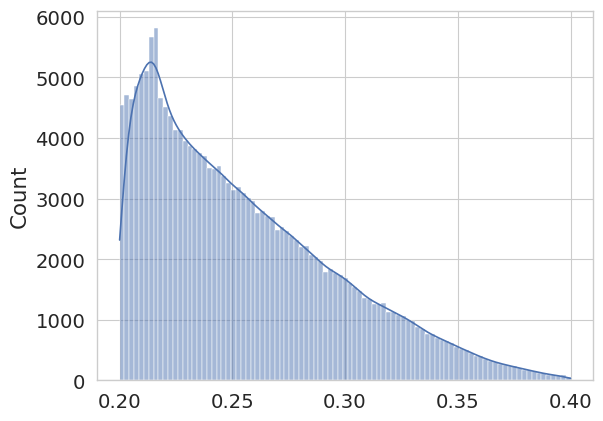

In [15]:

sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'


base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

stratified_beta_multilabel_middle(df, 2, 1, sampling_model, 30, dataset=sampling_dataset)

# While loop to reach the budget 

In [16]:
'''
* This is an odd variant of stratified beta sampling and is the same as vanilla
    stratified sampling but is using a while loop to reach the training budget 

* This ends up looking different from the beta distibution that we are going for 
    so its not something we want to stick with 
'''
def stratified_beta_multilabel_budget(df, alpha, beta, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()
    total_samples = round((training_budget*0.01) * len(all_ids))

    # sampled_question_ids = []
    # sampled_variabilities = []
    # sampled_confidence = []
    # sampled_correctness = []
    # sampled_targets = []

    #unique_targets = df['Target'].unique()
    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    #confidence = np.array(df['confidence'].tolist())
    variability = np.array(df['variability'].tolist())


    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    df_variability = pd.DataFrame({'variability':variability, 'question_id':question_ids})
    bins = pd.cut(variability, bins=np.linspace(0, 0.5, 6), right=True, retbins=True)
    df_variability['bins'] = bins[0]
    
    beta_distribution = scipy.stats.beta(alpha, beta)
    sampling_percentages = [beta_distribution.cdf(0.2), beta_distribution.cdf(0.4)-beta_distribution.cdf(0.2), beta_distribution.cdf(0.6)-beta_distribution.cdf(0.4), beta_distribution.cdf(0.8)-beta_distribution.cdf(0.6), beta_distribution.cdf(1) - beta_distribution.cdf(0.8)]
    #sampling_percentages = [beta_distribution.cdf(0.25), beta_distribution.cdf(0.5)-beta_distribution.cdf(0.25), beta_distribution.cdf(0.75)-beta_distribution.cdf(0.5), beta_distribution.cdf(1)-beta_distribution.cdf(0.75)]
    unique_bins = df_variability['bins'].unique().tolist()
    print(unique_bins)

    first_bin = df_variability.loc[df_variability['bins'] == unique_bins[2]]
    second_bin = df_variability.loc[df_variability['bins'] == unique_bins[0]]
    third_bin = df_variability.loc[df_variability['bins'] == unique_bins[1]]
    fourth_bin = df_variability.loc[df_variability['bins'] == unique_bins[3]]
    fifth_bin = df_variability.loc[df_variability['bins'] == unique_bins[4]]

    all_bins = [first_bin, second_bin, third_bin, fourth_bin, fifth_bin]
    final_sample = []
    final_sample_ids = []

    while len(final_sample_ids) < total_samples:
        for idx, sampling_percentage in enumerate(sampling_percentages):
            sampled_points = all_bins[idx].sample(frac=sampling_percentage, replace=False)
            if len(sampled_points) + len(final_sample) > total_samples:
                cropped = total_samples - len(final_sample)
                sampled_points = sampled_points.iloc[:cropped]
                all_bins[idx] = all_bins[idx][~all_bins[idx]['question_id'].isin(sampled_points['question_id'].tolist())]
                final_sample.extend(sampled_points['variability'].tolist())
                final_sample_ids.extend(sampled_points['question_id'].tolist())
            else:
                all_bins[idx] = all_bins[idx][~all_bins[idx]['question_id'].isin(sampled_points['question_id'].tolist())]
                final_sample.extend(sampled_points['variability'].tolist())
                final_sample_ids.extend(sampled_points['question_id'].tolist())

    sns.histplot(final_sample, kde=True)
    total_samples = round((training_budget*0.01) * len(all_ids))
    print("Total samples: ", total_samples)
    print("sample size: ", len(set(final_sample)))


    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/beta/var_stratified/seed_'+str(965)+'/alpha_'+str(alpha)+'_beta_'+str(beta)+'_budget_'+str(training_budget)+'budget.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    # sampled_targets_unique = [] # unique targets in sampled data
    # sampled_targets = set(unique_targets_sample['Target'].unique())
    # for sample in sampled_targets:
    #     target_list = [x.strip() for x in sample.split(',')]
    #     sampled_targets_unique.extend(target_list)
    # sampled_targets_unique = set(sampled_targets_unique)
    targets_excluded = unique_targets - unique_targets_sampled
    print("TARGETS excluded: ", len(targets_excluded))

    print("unique targets max variability per class: ", len(set(unique_targets_sampled)))
    print('samples - max variability per class: ', len(set(final_sample)))
    print('all_samples - max variability per class: ', len(all_ids))

[Interval(0.1, 0.2, closed='right'), Interval(0.2, 0.3, closed='right'), Interval(0.0, 0.1, closed='right'), Interval(0.3, 0.4, closed='right'), Interval(0.4, 0.5, closed='right')]
Total samples:  185817
sample size:  185817
TARGETS excluded:  1
unique targets max variability per class:  3127
samples - max variability per class:  185817
all_samples - max variability per class:  619390


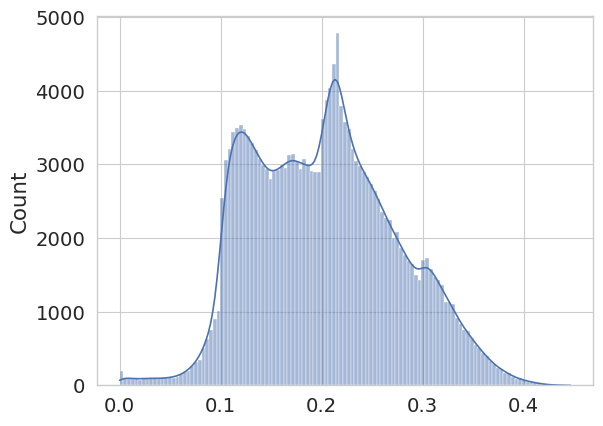

In [17]:

sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'


base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

stratified_beta_multilabel_budget(df, 2, 1, sampling_model, 30, dataset=sampling_dataset)